In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:
channel     = 4
run         = f'Run38SPheCH{channel}'
temperature = 7
pressure    = 7.5

run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 1
nevents_per_wvf = 2000

samples_per_waveform = 124
# samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 60
start = 1

In [4]:

# fixBaselines_Amp = {'CH1': -485.60
#                     ,'CH2': -486.59
#                     ,'CH3': -485.52
#                     ,'CH4': -485.15
#                     }
amp_offset = 600
fixBaselines_Amp = {'CH1': -amp_offset
                    ,'CH2': -amp_offset
                    ,'CH3': -amp_offset
                    ,'CH4': -amp_offset
                    }

In [5]:
parse_data.checkWfs(run_dir, 
                    1, 7, 
                    nchannels, 
                    samples_per_waveform, 
                    event_header_bytes, 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run38SPheCH4
Waveforms shape: (2000, 1, 124)
Waveforms shape: (2000, 1, 124)
Waveforms shape: (2000, 1, 124)
Waveforms shape: (2000, 1, 124)
Waveforms shape: (2000, 1, 124)
Waveforms shape: (2000, 1, 124)


In [6]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[start:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes
                                             )  
        dataframes.append(df)

Reading .bin files: 100%|██████████| 29/29 [00:12<00:00,  2.37file/s]


In [7]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [8]:
df = merged_df
df.rename(columns={'CH1': f'CH{channel}'}, inplace=True)
df.tail()

,TIME,CH4,event,event_time,file_idx
7191995,9.600000e-07,-173.286285,57999,1070536546,28
7191996,9.680000e-07,-92.533897,57999,1070536546,28
7191997,9.760000e-07,-30.435553,57999,1070536546,28
7191998,9.840000e-07,10.983798,57999,1070536546,28
7191999,9.920000e-07,33.565014,57999,1070536546,28


##  Data selection

In [9]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Events per file = {len(event_list)/len(os.listdir(run_dir)[start:nfiles])}. Total nevents = {len(event_list)}')

Events per file = 2000.0. Total nevents = 58000


In [10]:
channels = [f'CH{channel}']
# channels = ['CH1', 'CH2']

In [11]:
# selected_ev = 176573
selected_event = 50


In [12]:
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event

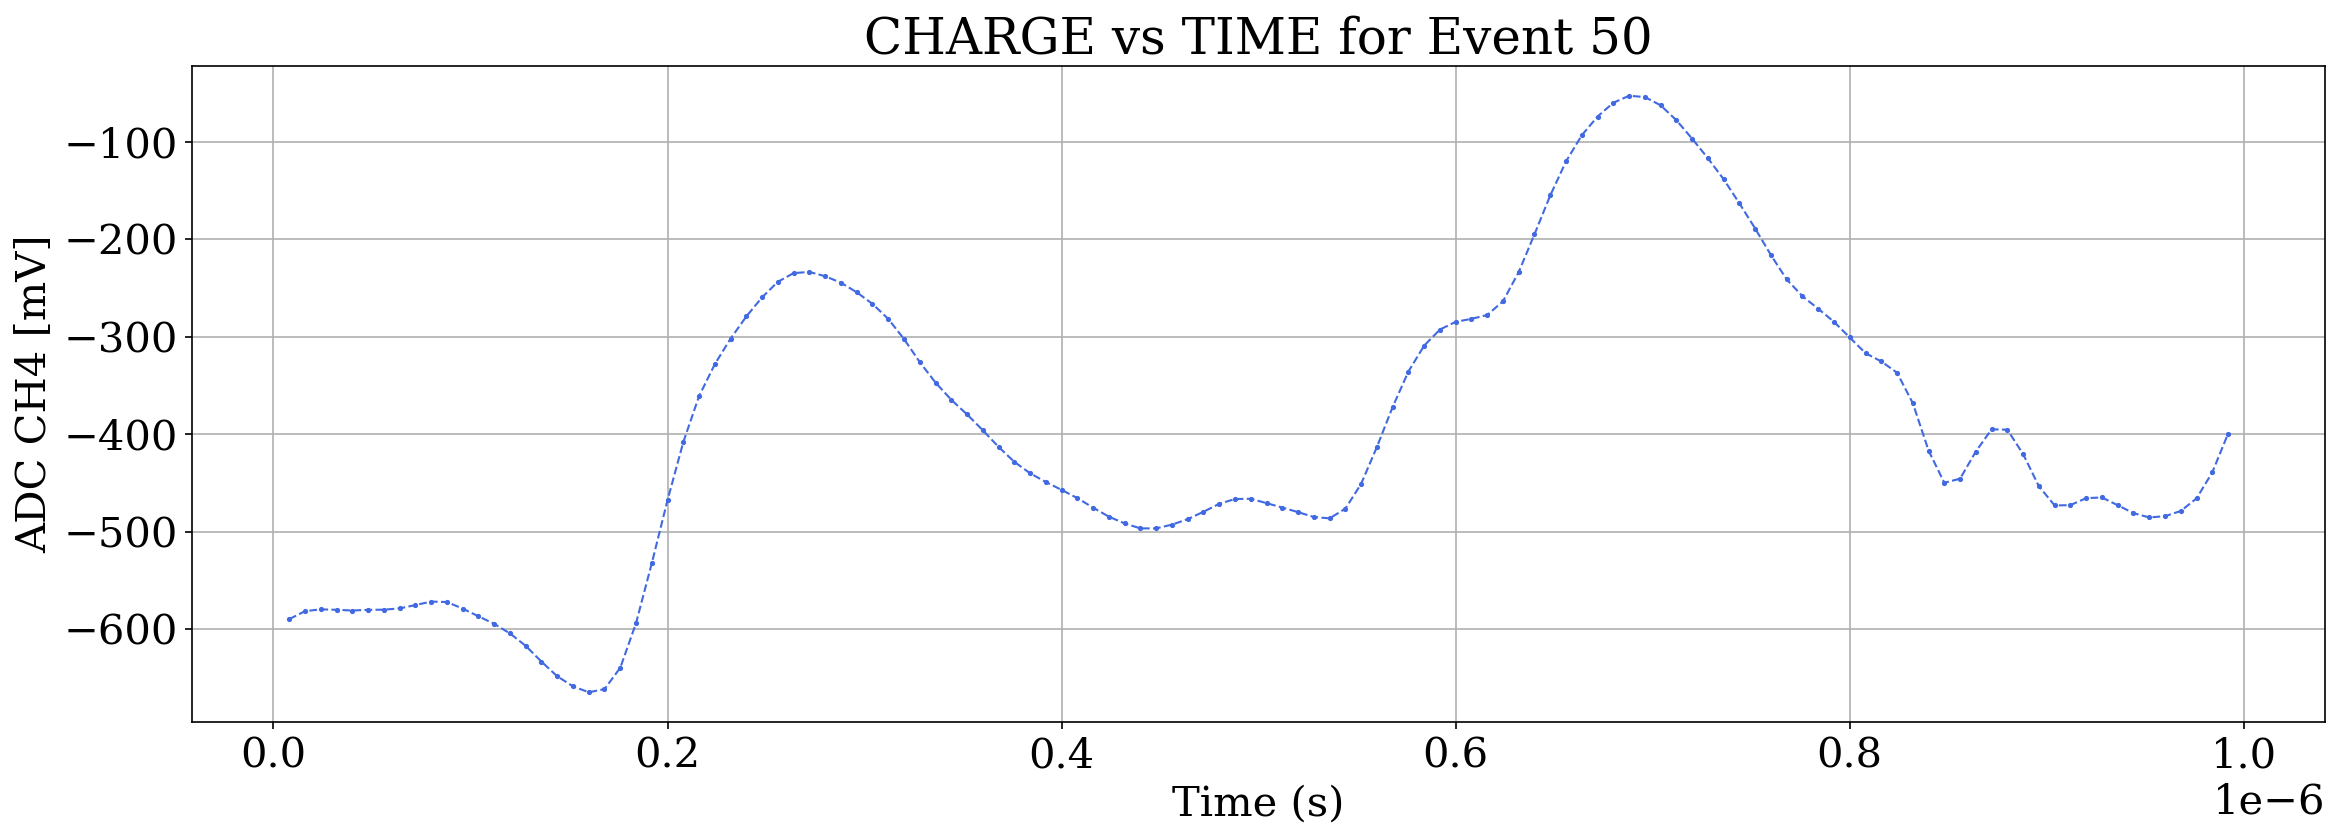

In [13]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

else:
    ax.set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    ax.plot(df_event['TIME'].values, df_event[f'{channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{channels[i]}')
    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')
# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Data filtering

In [14]:
0.2/1, 2/6

(0.2, 0.3333333333333333)

In [15]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, threshold=2000):
    peak_count = 0
    for ch in channels:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts = df.groupby("event").apply(count_high_peaks)

# keep only events with <= 5 peaks above 2000
valid_events = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = df[df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)

/tmp/ipykernel_116868/2307614243.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts = df.groupby("event").apply(count_high_peaks)


In [16]:
# DEFINITION OF THE BASELINE WINDOW WITH HERE
window_width = 20


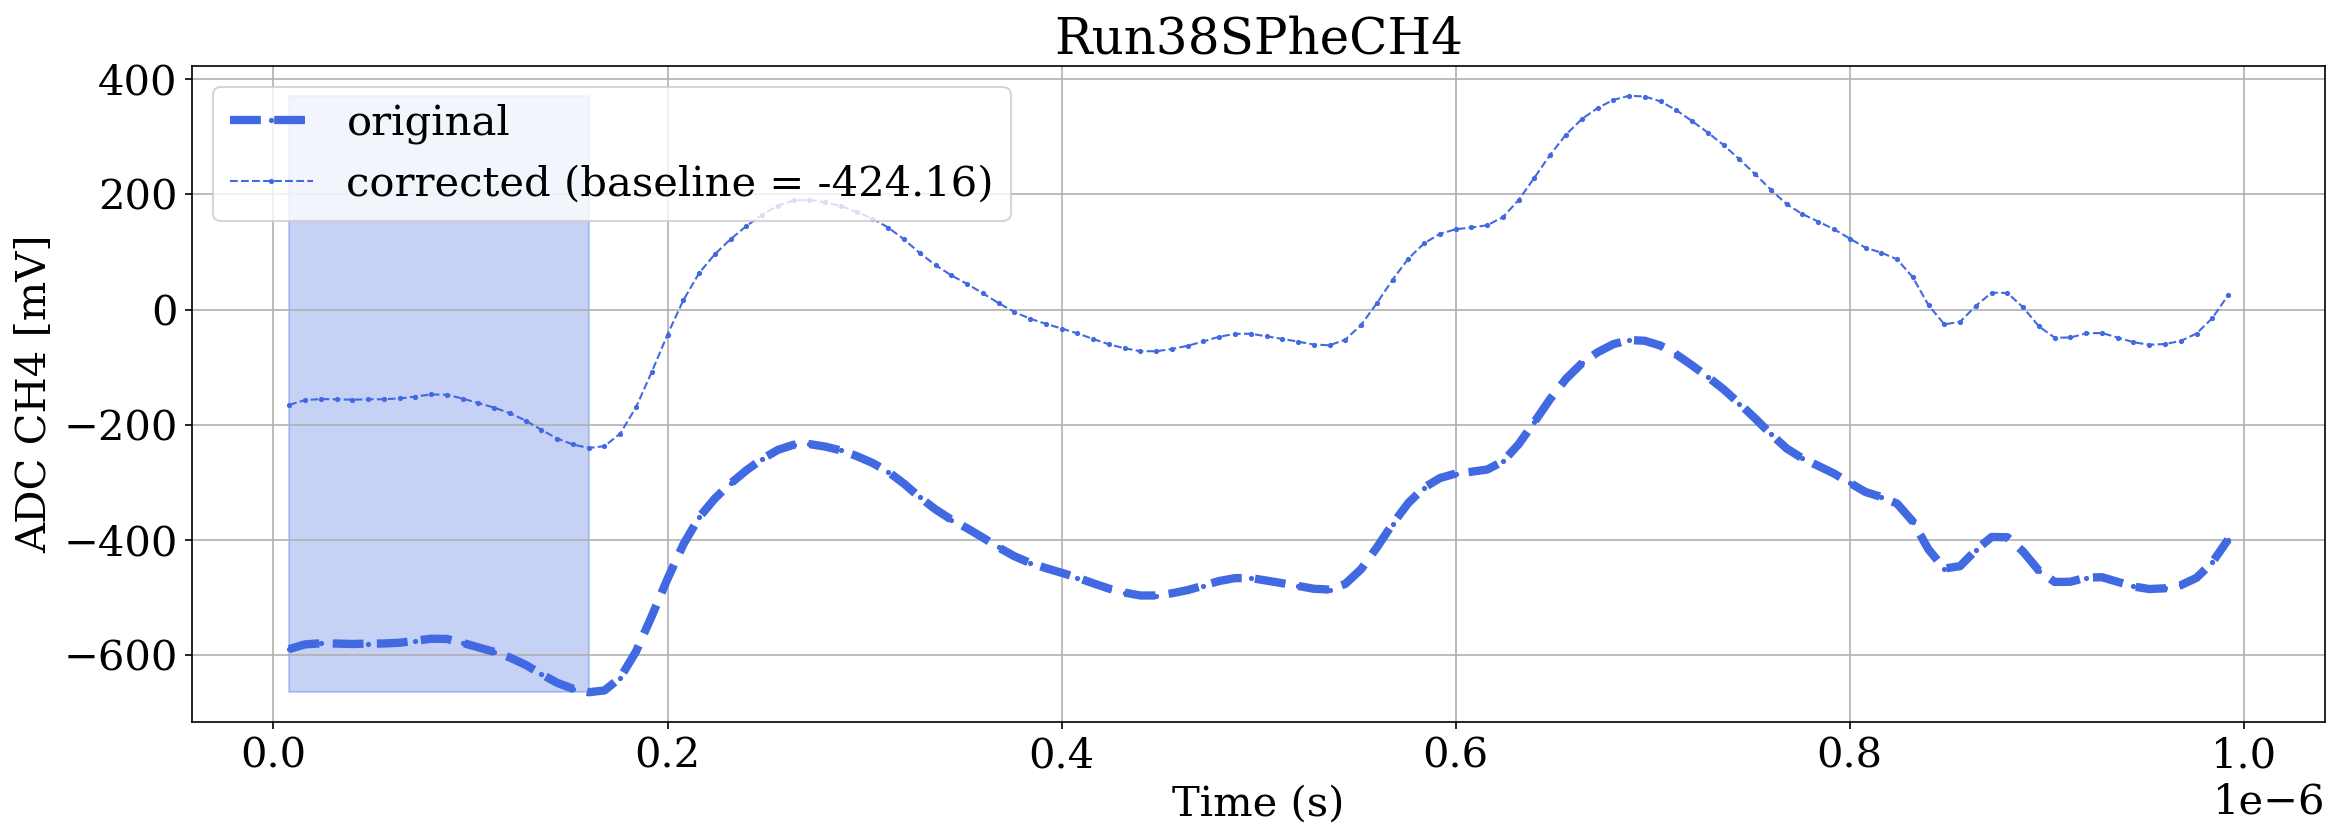

In [17]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_event], v_matrix[selected_event], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_event], v_matrix_corrected[selected_event], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected (baseline = {baselines[selected_event]:.2f})')
    

    start = max(window[selected_event], 0)
    end   = min(window[selected_event] + window_width, len(v_matrix[0]))
    ax.fill_between(time[start:end], 
                    v_matrix[selected_event].min(), 
                    v_matrix_corrected[selected_event].max(), color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Integration window

In [18]:
t_matrix = filtered_df['TIME'].values.reshape(nevents, -1)
time = t_matrix[0]

In [19]:
len(time), len(voltage)

(124, 7192000)

In [20]:
time_window = (0.18e-6 < time) & (time <= 0.45e-6)

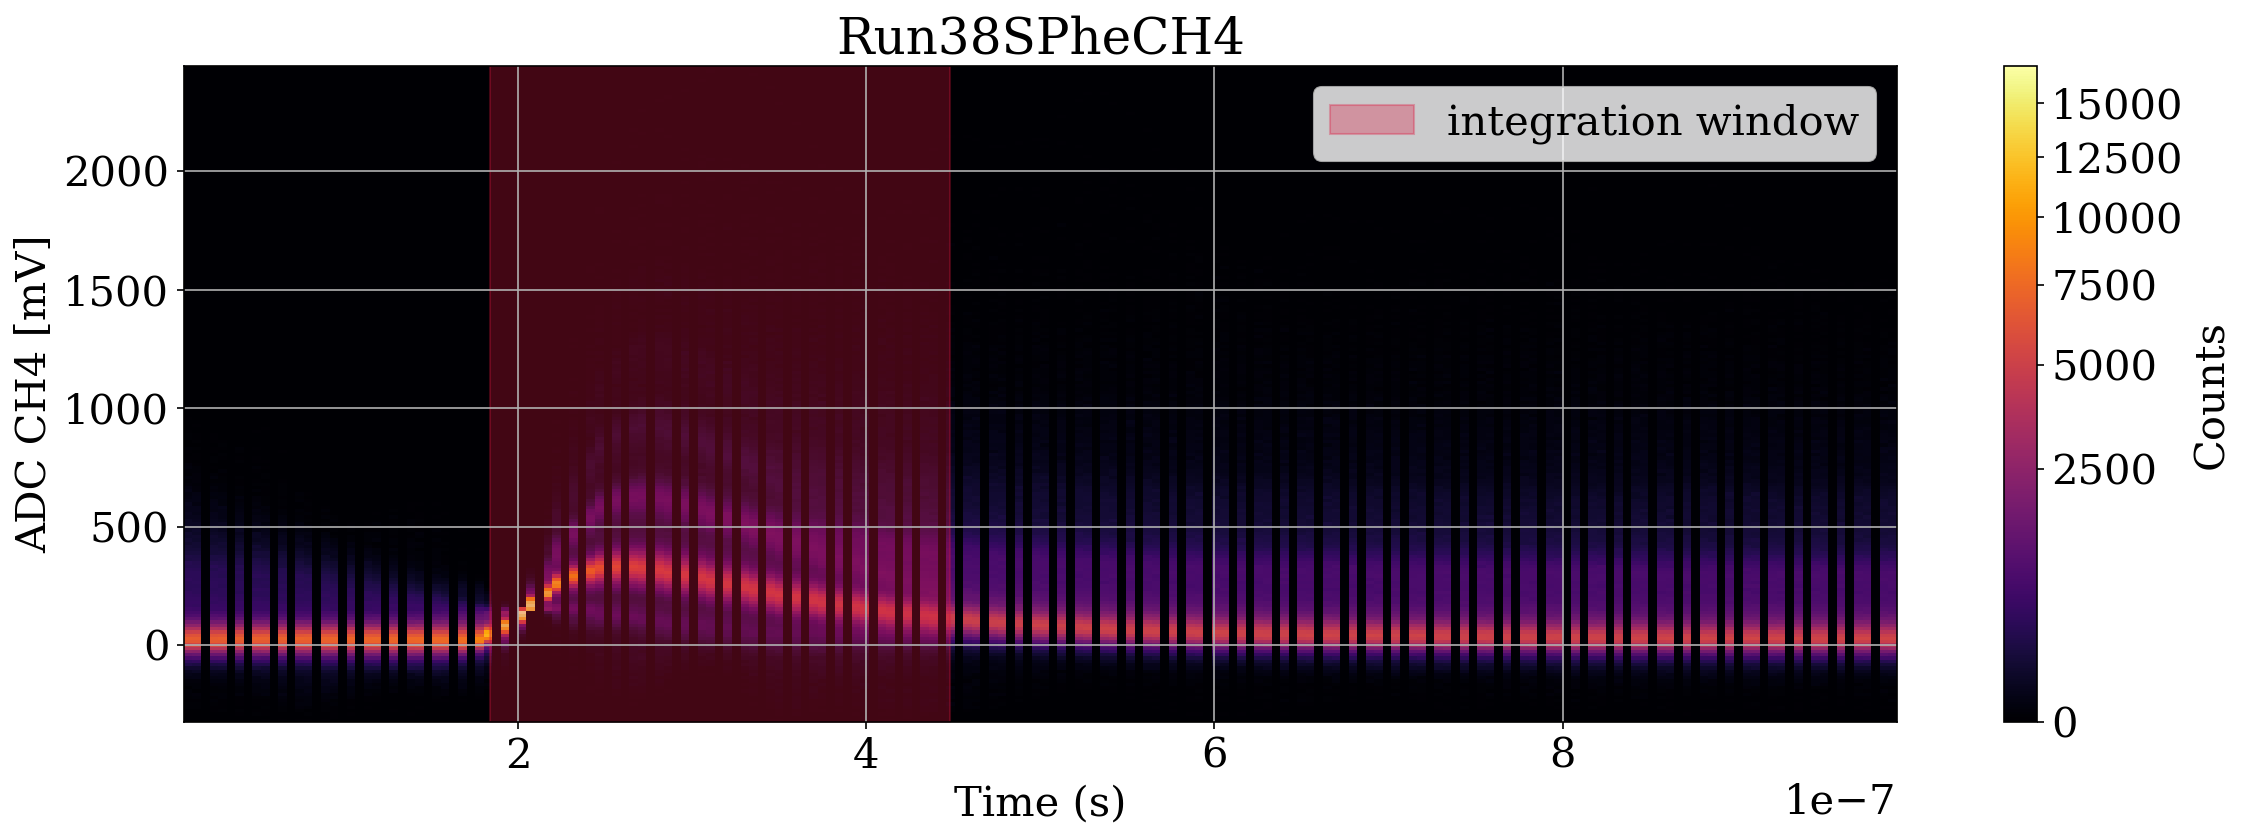

In [21]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'Run {run}')
else:
    ax.set_title(f'{run}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = filtered_df[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected    = v_matrix - fixBaselines_Amp[f'CH{i+1}']
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.5))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time[time_window], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [22]:
np.argmin(v_matrix_corrected.min(axis=1))

1881

In [23]:
np.shape(v_matrix_corrected), v_matrix_corrected.min()

((58000, 124), -324.909423828125)

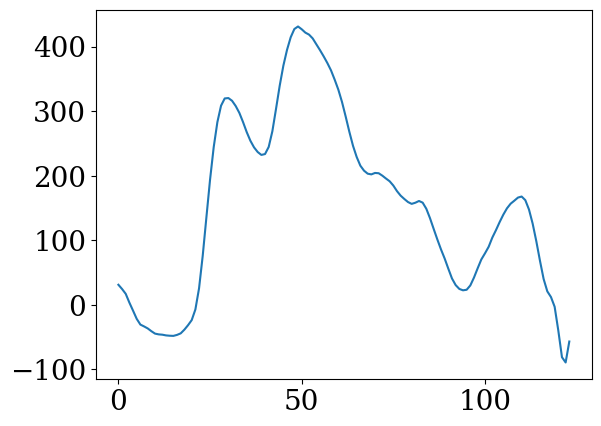

In [24]:
plt.plot(v_matrix_corrected[4])

In [25]:
np.argmin(v_matrix_corrected, axis = 0)

array([44408,  4746,  4746,  4746, 41014, 28050, 28050, 28050, 28050,
       28050, 28050, 28050, 28050, 28050, 28050, 37163, 37163, 37163,
       37163, 38255, 38255, 38255,  1903, 48322, 30332,   448, 17589,
       17589, 17589,  3954,  3954, 54601,  1881,  1881, 24729, 24729,
       53957, 53957, 26229, 30144, 33871, 33871,  1881,  1881, 38661,
       26229, 26229, 38920, 38920, 38920, 38920, 38920, 38920, 10777,
       25079, 18600, 18600, 18600,  3642, 40776,  3642,  3642, 29360,
       29360, 53207, 53207, 18512,  3523,  3523,  3523,  3523,  3523,
        3523,  3523,  3523,  3523,  3523,  3523,  3523, 56557, 56557,
       49496, 22455, 22455, 22455, 22455, 22455, 22455, 44408, 44408,
       25916, 25916, 44408, 44408, 44408, 44408,  4746,  4746,  4746,
        4746,  4746, 32750,  4746,  4746, 25674, 25674, 25674, 25674,
       25674, 25674, 25674, 25674, 25674,  8254,  8254,  8254, 44279,
       44279, 44279, 28646, 28646, 28646, 28646, 28646])

# CHARGE

##  Finger Plot

In [ ]:
# Create subplots: 2 rows, 1 column
def FingerPlot(df, channels, n_gaussians):

    opt_A, opt_mu, opt_sigma, opt_mu_errors = {}, {}, {}, {}
    if len(channels) > 1:
        fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*10), dpi=150, sharex=True)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, sharex=True)

    if len(channels) > 1:
        axs[0].set_title(f'Run {run}')
    else:
        ax.set_title(f'{run}')


    # Plot CHs
    for i in range(len(channels)):

        if len(channels) > 1:
            ax = axs[i]

        voltage = df[f'{channels[i]}'].values

        v_matrix                    = voltage.reshape(nevents, -1)
        # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
        v_matrix_corrected    = v_matrix - fixBaselines_Amp[f'CH{i+1}']
        # v_matrix_corrected    = v_matrix - (-485)


        charge = np.trapz(v_matrix_corrected[:, time_window],
                        x = time[time_window]
                        ,axis = 1)

        events, bins, image = ax.hist(charge
                                    ,bins = int(np.sqrt(len(charge))) 
                                    ,range = (4e-5, 3e-4)
                                    # ,range = (1.e-5, 3.5e-4)
                                    # ,range = (4.5e-5, 5e-4)
                                    # ,range = (5.5e-5, 5.5e-4)
                                    ,density = False
                                    ,alpha = 0.3
                                    ,label = f'{channels[i]}'
                                    )
        

        bins_means = (bins[:-1] + bins[1:])/2

         # Find peaks
        # peaks, _        = find_peaks(events, distance=40)
        peaks, _ = find_peaks(events, distance=50, prominence = 0.2)

        msk = (bins_means > (bins_means[events.argmax()] + bins_means[0])*0.45) & (bins_means < bins_means[peaks[n_gaussians]]*1.15)

        x = bins_means[msk]
        y = events[msk]

        # initial_guess_A     = list(events[peaks][:n_gaussians]*1e-2)
        initial_guess_A     = list(events[peaks][:n_gaussians])
        initial_guess_mu    = list(bins_means[peaks][:n_gaussians])
        # initial_guess_sigma = list(np.diff(bins_means[peaks])[:n_gaussians]/5)
        # initial_guess_sigma = [0.7 * (bins_means[1] - bins_means[0])] * n_gaussians
        # initial_guess_sigma = [0.8 * (bins_means[1] - bins_means[0])] * n_gaussians
        initial_guess_sigma = [0.6 * (bins_means[1] - bins_means[0])] * n_gaussians

        # ax.plot(initial_guess_mu, events[peaks][:n_gaussians], 'or', alpha = 0.3, markersize = 10)

        # Initial guesses for the parameters
        initial_guess = initial_guess_A + initial_guess_mu + initial_guess_sigma

        # Perform the fit with bounds to keep parameters positive
        # bounds = (0, 2e7)  # All parameters must be > 0

        # Perform the fit
        params, covariance = curve_fit(cig.sum_of_gaussians, x, y, p0=initial_guess, maxfev=100000)

        for j in range(10):
            # Fit the model to the data
            lower = np.minimum(params * 0.8, params * 1.2)
            upper = np.maximum(params * 0.8, params * 1.2)
            bounds = (lower, upper)
            if any(bounds[0] - bounds[1] > 0):
                print(j)
                print(params*0.8 - params*1.2)
            params, covariance = curve_fit(cig.sum_of_gaussians, x, y, p0=params, bounds = bounds, maxfev=100000)

        # Extract the optimized parameters
        # Extract optimized parameters (split them into A, mu, sigma)
        opt_A[f'CH{i}'] = params[:n_gaussians]
        opt_mu[f'CH{i}'] = params[n_gaussians:2*n_gaussians]
        opt_sigma[f'CH{i}'] = params[2*n_gaussians:]
        # Extract errors (standard deviations) for each mu
        opt_mu_errors[f'CH{i}'] = np.sqrt(np.diag(covariance)[n_gaussians:2*n_gaussians])

        gaussian_sum = cig.sum_of_gaussians(x, *params)
        ax.plot(x, gaussian_sum, lw = 3, alpha = 0.8, label = 'Gaussian Fit')

        markers = ['*', 'D', 'X', 'o', 'P', '^', 's']
        for jj, mu in enumerate(opt_mu[f'CH{i}'][:None]):
            ax.plot(mu, cig.sum_of_gaussians(mu, *params), 'X', color = colors[jj], label = fr" $\mu_{jj+1}$ = {mu:.2E} [V $\cdot$ s]", markersize = 10)
            one_gaussian_params = [opt_A[f'CH{i}'][jj], opt_mu[f'CH{i}'][jj], opt_sigma[f'CH{i}'][jj]]
            ax.plot(x, cig.sum_of_gaussians(x, *one_gaussian_params), '--', color = colors[jj])

        ax.set_ylabel(f'Counts')
        ax.grid(True)
        ax.legend()

    if len(channels) > 1:
        axs[-1].set_xlabel(r'Charge [mV $\cdot$ s]')
    else:
        ax.set_xlabel(r'Charge [mV $\cdot$ s]')
        
    # ax.set_yscale('log')

    return opt_A, opt_mu, opt_sigma, opt_mu_errors
    # plt.xlim(-2e-7,40e-7)

# # Improve layout
# plt.tight_layout()
# plt.show()

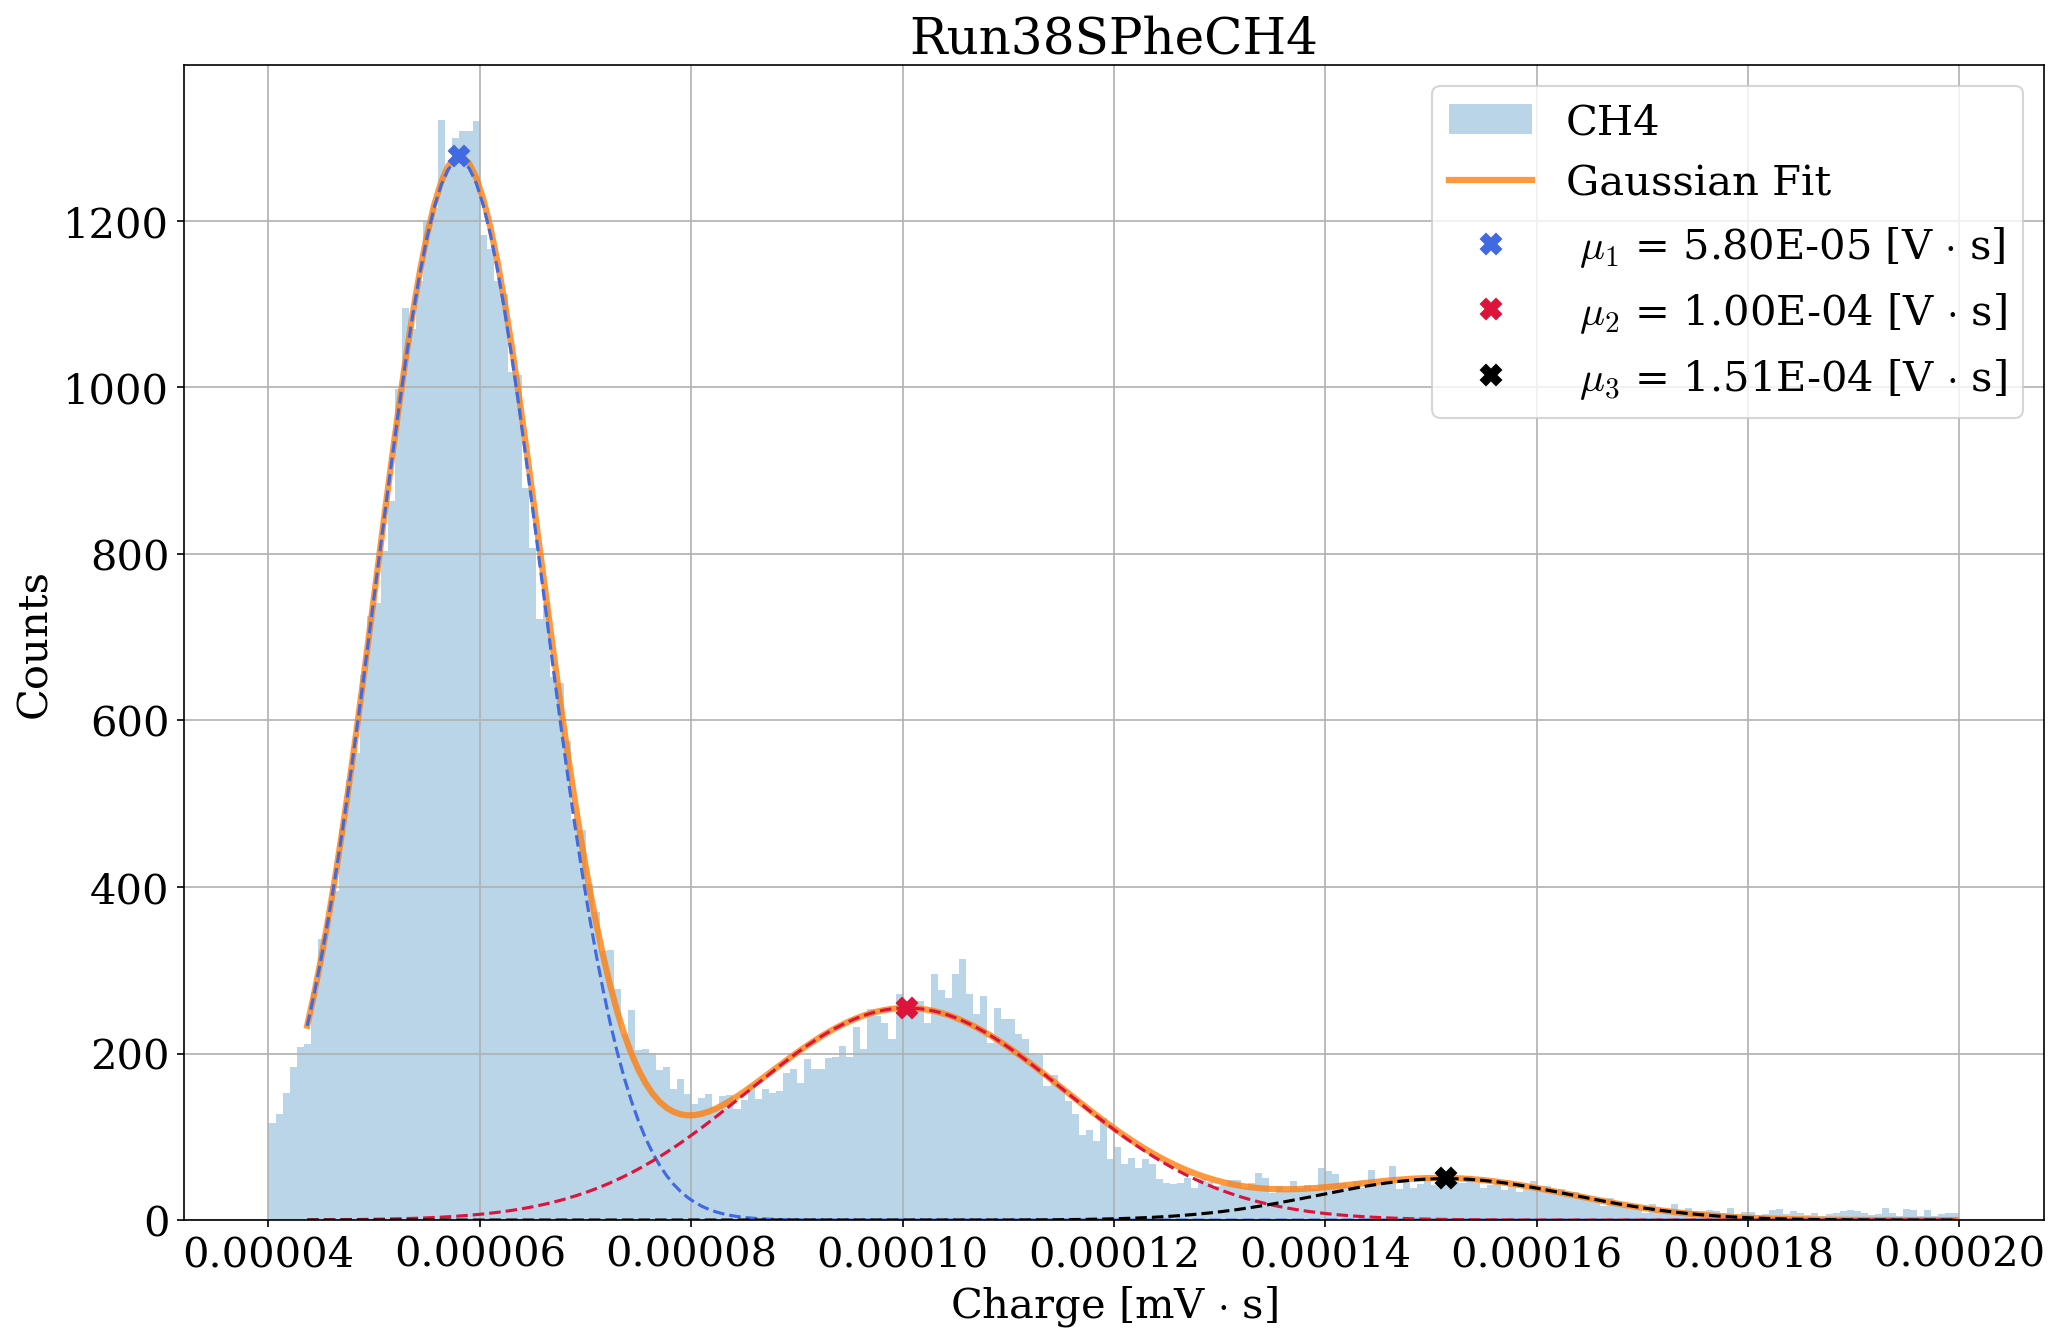

In [ ]:
n_gaussians = 4
opt_A, opt_mu, opt_sigma, opt_mu_errors =  FingerPlot(filtered_df, channels, n_gaussians)

##  Data Analysis: Linearity

In [35]:
opt_mu

{'CH0': array([5.80330555e-05, 1.00382083e-04, 1.51414896e-04])}

In [36]:
pes_spectrum = opt_mu
err_spectrum = opt_mu_errors

In [37]:
# npeaks = -1 # all except last one
npeaks = None # all 


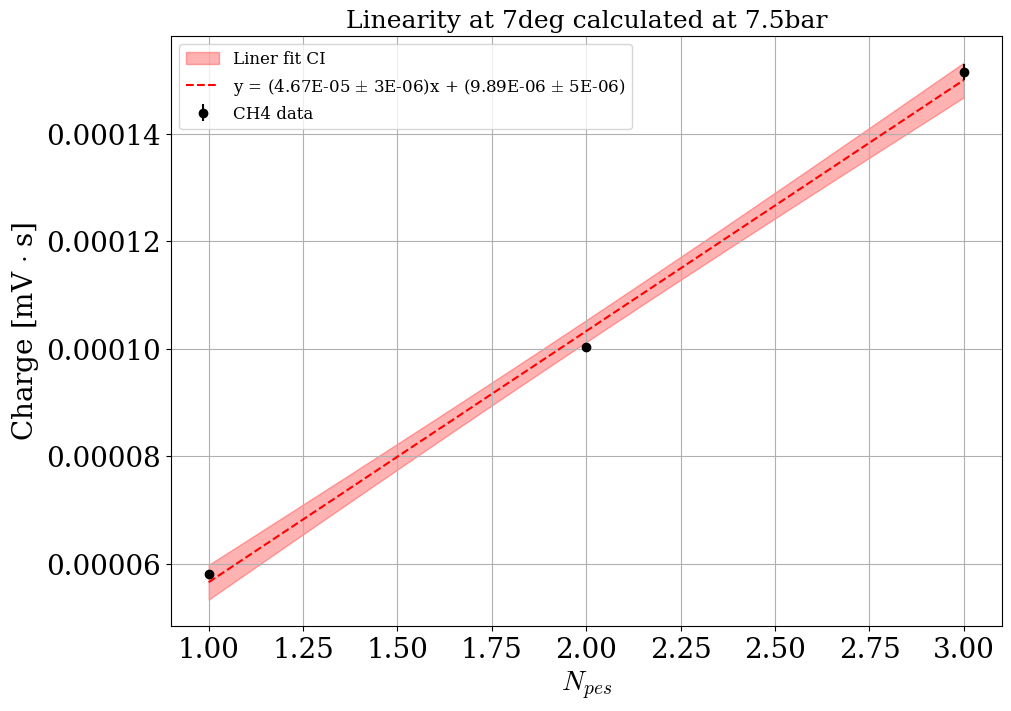

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20

for ch in pes_spectrum.keys():
# for ch in ['CH3']:

    x = np.arange(len(pes_spectrum[ch][:npeaks])) + 1
    y = pes_spectrum[ch][:npeaks]
    order = np.argsort(y)
    y = y[order]

    # Perform linear fit and get covariance matrix
    params, cov = np.polyfit(x, y, 1, cov=True)
    slope, intercept = params

    # Get errors (standard deviations) from the covariance matrix
    slope_err = np.sqrt(cov[0, 0])
    intercept_err = np.sqrt(cov[1, 1])

    # Fitted line
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = slope * x_fit + intercept

    y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
    y_fit_err = np.sqrt(y_fit_var)

    ax.errorbar(x, y, yerr = err_spectrum[ch][:npeaks][order],  fmt = 'o', alpha = 1,
                color='k', label = fr'CH{channel} data')
    
  # Plot fit confidence band (before fit line so line is on top)
    ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err,
                    color='r', alpha=0.3, label=f'Liner fit CI')

    ax.plot(x_fit, y_fit, '--r', label = f'y = ({slope:.2E} $\pm$ {slope_err:.0E})x + ({intercept:.2E} $\pm$ {intercept_err:.0E})')


ax.set_title(f'Linearity at {temperature}deg calculated at {pressure}bar', fontsize = 0.9*font_size);
ax.set_xlabel(r'$N_{pes}$', fontsize = font_size);
ax.set_ylabel(r'Charge [mV $\cdot$ s]', fontsize = font_size);
ax.grid(True)

ax.legend(fontsize = font_size*0.6, loc = 'upper left')

# PEAK VOLTAGE

##  Finger Plot

In [39]:
# Create subplots: 2 rows, 1 column
def FingerPlotVoltage(df, channels, n_gaussians):

    opt_A, opt_mu, opt_sigma, opt_mu_errors = {}, {}, {}, {}
    if len(channels) > 1:
        fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*10), dpi=150, sharex=True)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, sharex=True)

    if len(channels) > 1:
        axs[0].set_title(f'Run {run}')
    else:
        ax.set_title(f'{run}')


    # Plot CHs
    for i in range(len(channels)):

        if len(channels) > 1:
            ax = axs[i]

        voltage = df[f'{channels[i]}'].values

        v_matrix                    = voltage.reshape(nevents, -1)
        # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
        v_matrix_corrected    = v_matrix - fixBaselines_Amp[f'CH{i+1}']
        # v_matrix_corrected    = v_matrix - (-485)


        peak_mV = np.max(v_matrix[:, time_window], axis=1)
        # peak_mV = np.max(v_matrix_corrected[:, time_window], axis=1)

        events, bins, image = ax.hist(peak_mV
                                    ,bins = int(np.sqrt(len(peak_mV))) 
                                    ,range = (-450, 1000)
                                    ,density = False
                                    ,alpha = 0.3
                                    ,label = f'{channels[i]}'
                                    )
        

        bins_means = (bins[:-1] + bins[1:])/2

         # Find peaks
        # peaks, _        = find_peaks(events, distance=40)
        peaks, _ = find_peaks(events, distance=50, prominence = 0.2)

        msk = (bins_means > (bins_means[events.argmax()] + bins_means[0])*0.45) & (bins_means < bins_means[peaks[n_gaussians]]*1.15)

        x = bins_means[msk]
        y = events[msk]

        # initial_guess_A     = list(events[peaks][:n_gaussians]*1e-2)
        initial_guess_A     = list(events[peaks][:n_gaussians])
        initial_guess_mu    = list(bins_means[peaks][:n_gaussians])
        # initial_guess_sigma = list(np.diff(bins_means[peaks])[:n_gaussians]/5)
        # initial_guess_sigma = [0.6 * (bins_means[1] - bins_means[0])] * n_gaussians
        initial_guess_sigma = [0.2 * (bins_means[1] - bins_means[0])] * n_gaussians

        # ax.plot(initial_guess_mu, events[peaks][:n_gaussians], 'or', alpha = 0.3, markersize = 10)

        # Initial guesses for the parameters
        initial_guess = initial_guess_A + initial_guess_mu + initial_guess_sigma

        # Perform the fit with bounds to keep parameters positive
        # bounds = (0, 2e7)  # All parameters must be > 0

        # Perform the fit
        params, covariance = curve_fit(cig.sum_of_gaussians, x, y, p0=initial_guess, maxfev=100000)

        for j in range(10):
            # Fit the model to the data
            lower = np.minimum(params * 0.8, params * 1.2)
            upper = np.maximum(params * 0.8, params * 1.2)
            bounds = (lower, upper)
            if any(bounds[0] - bounds[1] > 0):
                print(j)
                print(params*0.8 - params*1.2)
            params, covariance = curve_fit(cig.sum_of_gaussians, x, y, p0=params, bounds = bounds, maxfev=100000)

        # Extract the optimized parameters
        # Extract optimized parameters (split them into A, mu, sigma)
        opt_A[f'CH{i}'] = params[:n_gaussians]
        opt_mu[f'CH{i}'] = params[n_gaussians:2*n_gaussians]
        opt_sigma[f'CH{i}'] = params[2*n_gaussians:]
        # Extract errors (standard deviations) for each mu
        opt_mu_errors[f'CH{i}'] = np.sqrt(np.diag(covariance)[n_gaussians:2*n_gaussians])

        gaussian_sum = cig.sum_of_gaussians(x, *params)
        ax.plot(x, gaussian_sum, lw = 3, alpha = 0.8, label = 'Gaussian Fit')

        markers = ['*', 'D', 'X', 'o', 'P', '^', 's']
        for jj, mu in enumerate(opt_mu[f'CH{i}'][:None]):
            ax.plot(mu, cig.sum_of_gaussians(mu, *params), 'X', color = colors[jj], label = fr" $\mu_{jj+1}$ = {mu:.2f} [mV]", markersize = 10)
            one_gaussian_params = [opt_A[f'CH{i}'][jj], opt_mu[f'CH{i}'][jj], opt_sigma[f'CH{i}'][jj]]
            ax.plot(x, cig.sum_of_gaussians(x, *one_gaussian_params), '--', color = colors[jj])

        ax.set_ylabel(f'Counts')
        ax.grid(True)
        ax.legend()

    if len(channels) > 1:
        axs[-1].set_xlabel(r'Peak value [mV]')
    else:
        ax.set_xlabel(r'Peak value [mV]')
        
    # ax.set_yscale('log')

    return opt_A, opt_mu, opt_sigma, opt_mu_errors
    # plt.xlim(-2e-7,40e-7)

# # Improve layout
# plt.tight_layout()
# plt.show()

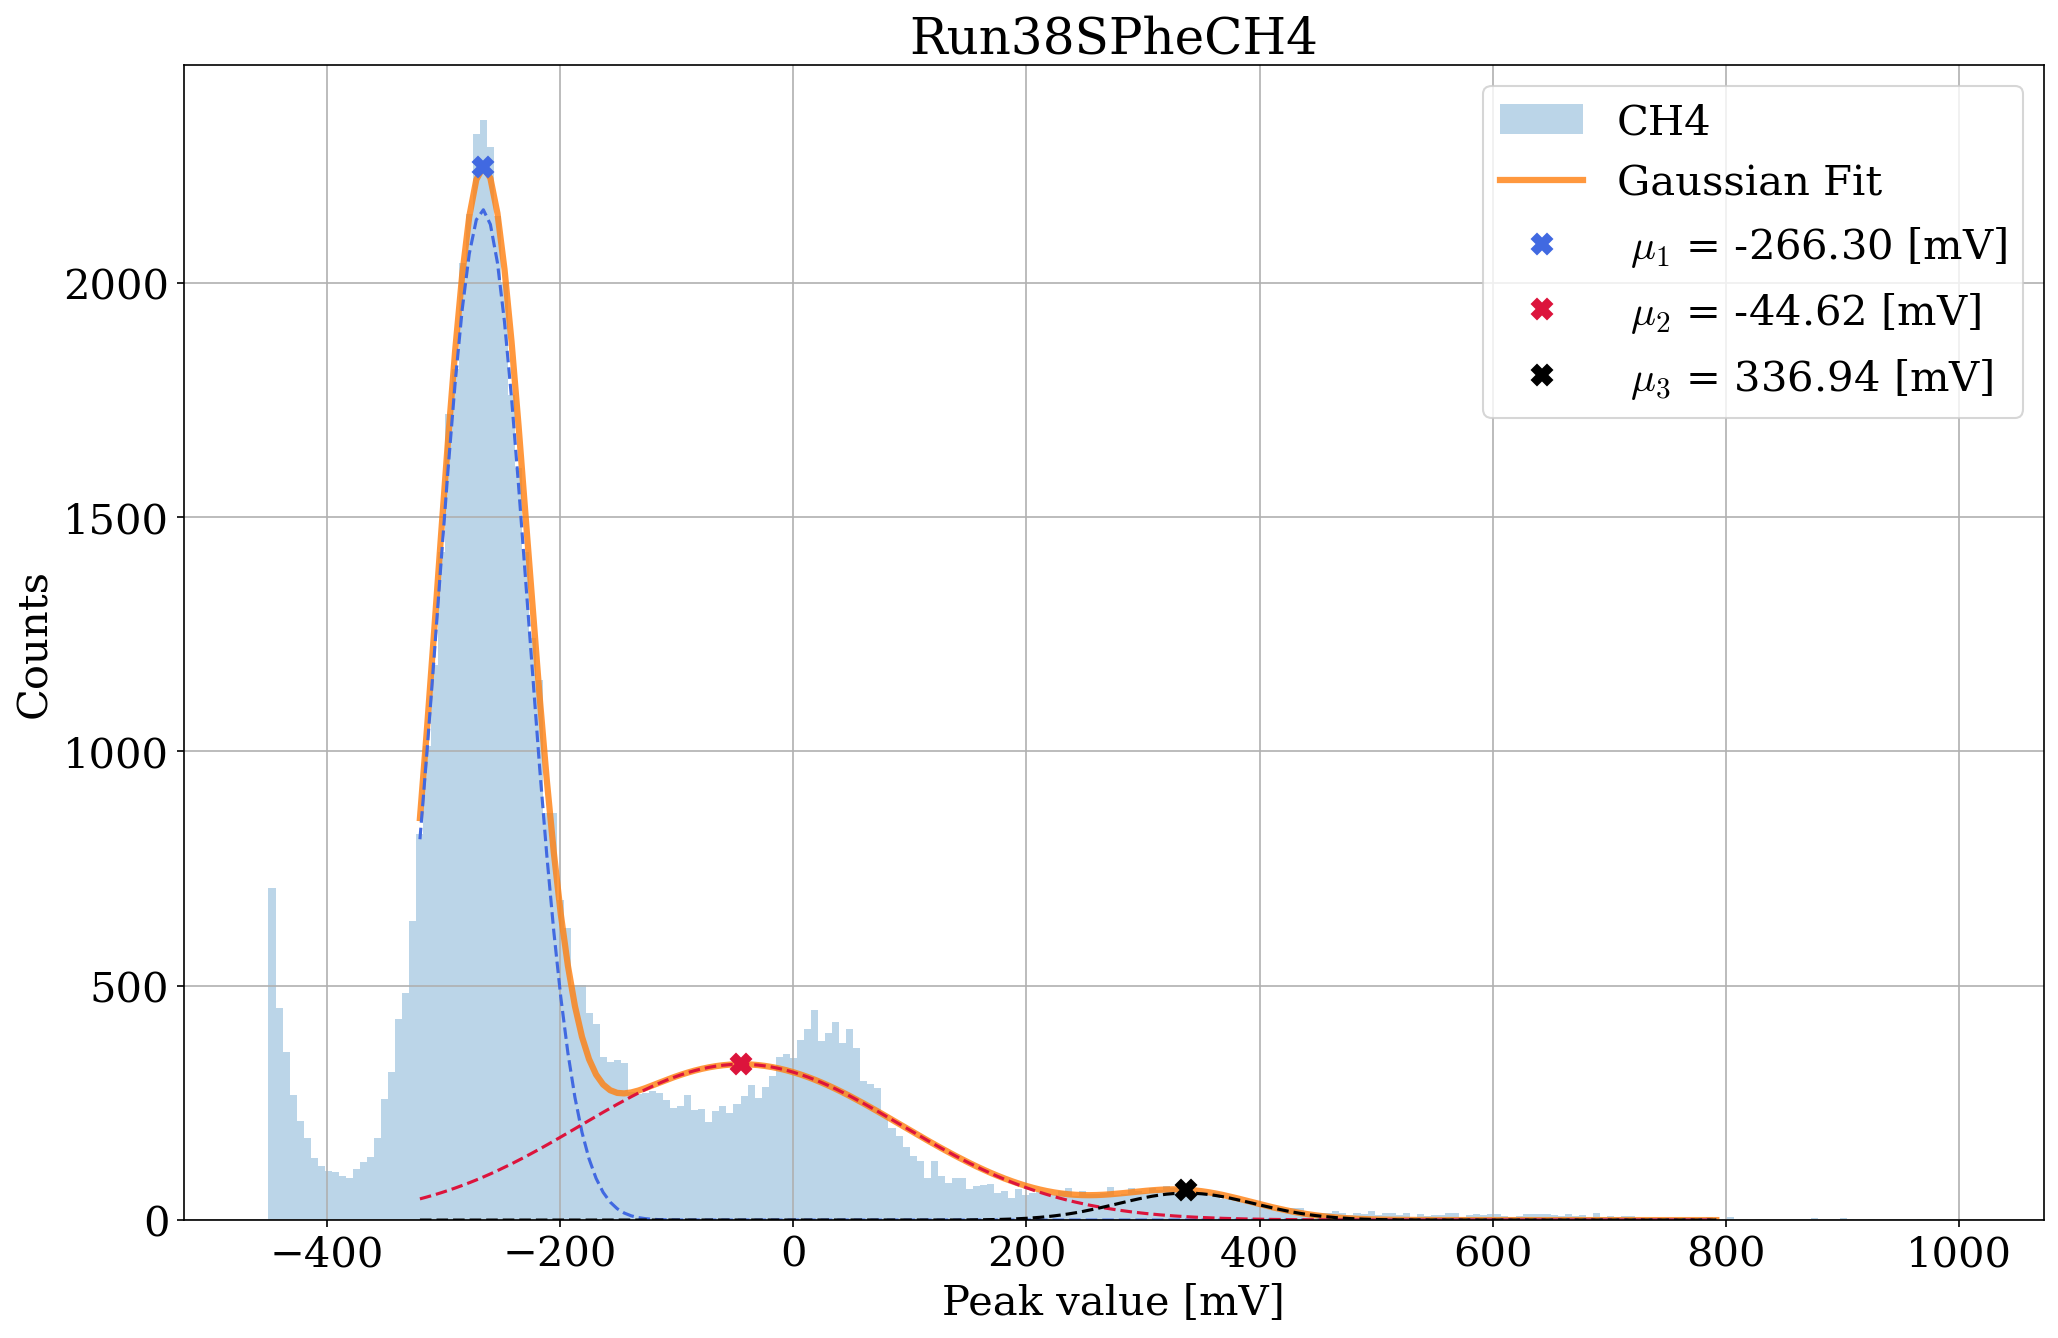

In [40]:
n_gaussians = 3
opt_A, opt_mu, opt_sigma, opt_mu_errors =  FingerPlotVoltage(filtered_df, channels, n_gaussians)

In [41]:
opt_sigma

{'CH0': array([ 38.51791536, 137.91654007,  58.71484168])}

##  Data Analysis: Linearity

In [42]:
opt_mu

{'CH0': array([-266.29546015,  -44.6201126 ,  336.93607653])}

In [43]:
pes_spectrum = opt_mu
err_spectrum = opt_mu_errors

In [44]:
# npeaks = -1 # all except last one
npeaks = None # all 


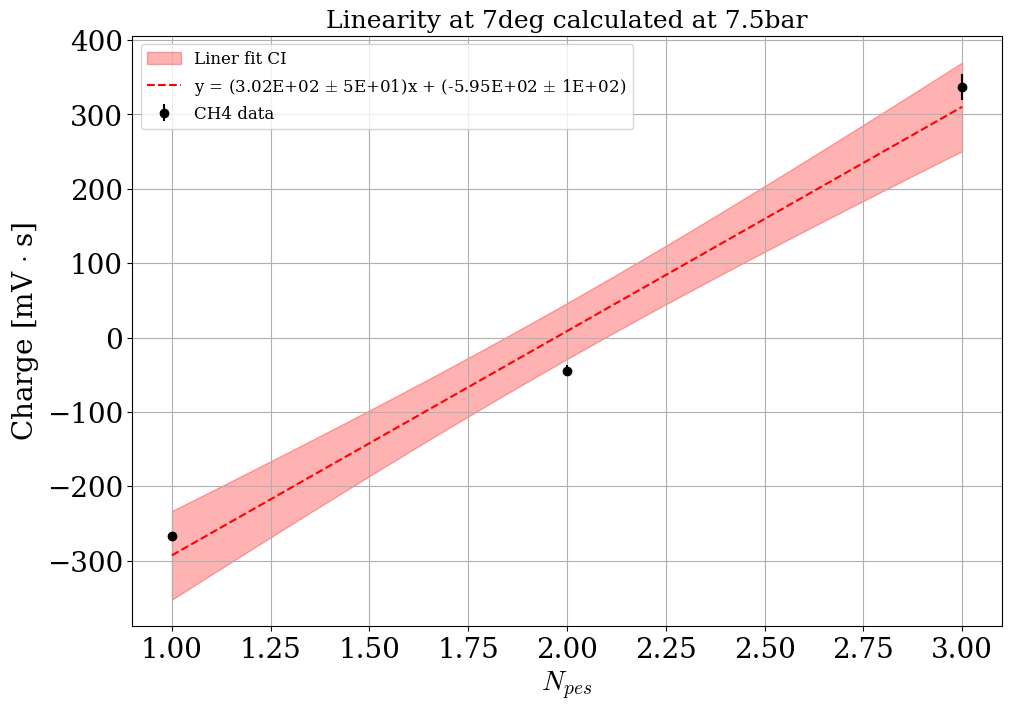

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20

for ch in pes_spectrum.keys():
# for ch in ['CH3']:

    x = np.arange(len(pes_spectrum[ch][:npeaks])) + 1
    y = pes_spectrum[ch][:npeaks]
    order = np.argsort(y)
    y = y[order]

    # Perform linear fit and get covariance matrix
    params, cov = np.polyfit(x, y, 1, cov=True)
    slope, intercept = params

    # Get errors (standard deviations) from the covariance matrix
    slope_err = np.sqrt(cov[0, 0])
    intercept_err = np.sqrt(cov[1, 1])

    # Fitted line
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = slope * x_fit + intercept

    y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
    y_fit_err = np.sqrt(y_fit_var)

    ax.errorbar(x, y, yerr = err_spectrum[ch][:npeaks][order],  fmt = 'o', alpha = 1,
                color='k', label = fr'CH{channel} data')
    
  # Plot fit confidence band (before fit line so line is on top)
    ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err,
                    color='r', alpha=0.3, label=f'Liner fit CI')

    ax.plot(x_fit, y_fit, '--r', label = f'y = ({slope:.2E} $\pm$ {slope_err:.0E})x + ({intercept:.2E} $\pm$ {intercept_err:.0E})')


ax.set_title(f'Linearity at {temperature}deg calculated at {pressure}bar', fontsize = 0.9*font_size);
ax.set_xlabel(r'$N_{pes}$', fontsize = font_size);
ax.set_ylabel(r'Charge [mV $\cdot$ s]', fontsize = font_size);
ax.grid(True)

ax.legend(fontsize = font_size*0.6, loc = 'upper left')